In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.image import random_crop, random_flip_left_right, random_flip_up_down
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras.models import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import load_img
from sklearn.metrics import classification_report
from sklearn.utils import shuffle
from PIL import Image, ImageEnhance
from tqdm import tqdm
import random

In [2]:
import tensorflow as tf

In [3]:
x_train_paths = []
y_train_paths = []
x_val_paths = []
y_val_paths = []

all_paths = []
all_labels = []
data_dir = './dataset'
for label in os.listdir(data_dir):
    for image in os.listdir(data_dir + "/" + label):
        all_paths.append(data_dir + "/" + label + '/' +image)
        all_labels.append(label)
all_paths, all_labels = shuffle(all_paths, all_labels)

x_train_paths = all_paths[:5000]
y_train = all_labels[:5000]
x_val_paths = all_paths[5000:]
y_val = all_labels[5000:]

In [4]:
def augment_image(image):
    image = tf.convert_to_tensor(np.uint8(image))    
    image = random_flip_left_right(image)
    image = random_flip_up_down(image)
    image = random_crop(image, (224, 224, 3))
    image = np.array(image)/255.0
    image = tf.convert_to_tensor(image)
    return image


In [5]:
def open_images(paths):
    images = []
    for path in paths:
        image = load_img(path, target_size=(256,256))
        image = augment_image(image)
        images.append(image)
    return np.array(images)

2022-02-26 18:52:27.955602: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-26 18:52:28.894609: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9659 MB memory:  -> device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:60:00.0, compute capability: 7.5


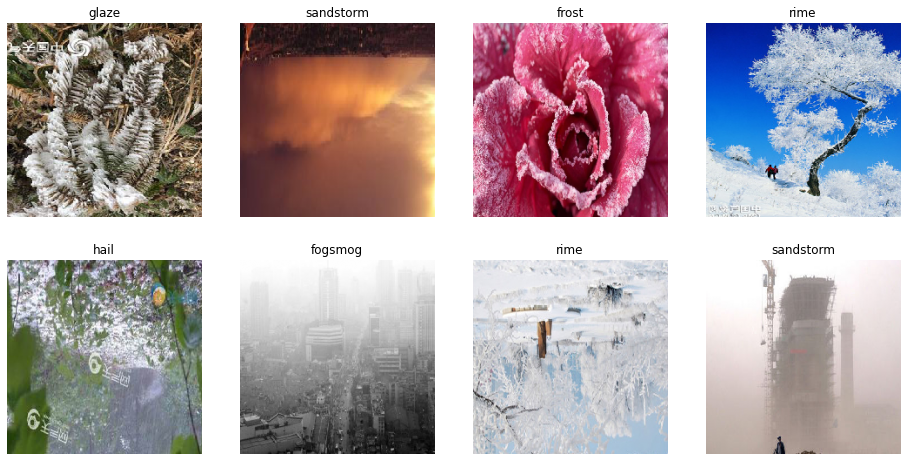

In [6]:
num_images = 9
images = open_images(x_train_paths[:num_images])
fig = plt.figure(figsize=(16, round(num_images/4)*4))
for x in range(1, num_images):
    fig.add_subplot(int(num_images/4), 4, x)
    plt.axis('off')
    plt.title(y_train[x])
    plt.imshow(images[x])
plt.show()

In [7]:
unique_labels = os.listdir(data_dir)
def encode_label(labels):
    encoded = []
    for x in labels:
        encoded.append(unique_labels.index(x))
    return np.array(encoded)

def decode_label(labels):
    decoded = []
    for x in labels:
        decoded.append(unique_labels[x])
    return np.array(decoded)

In [8]:
def data_gen(paths, labels, batch_size=32):
    
    if len(paths)!=len(labels):
        raise Exception('The length of paths is ',len(paths), ' but the length of labels is ', len(labels))
    
    for x in range(0, len(paths), batch_size):
        batch_paths = paths[x:x+batch_size]
        batch_images = open_images(batch_paths)
        batch_labels = labels[x:x+batch_size]
        batch_labels = encode_label(batch_labels)
        yield batch_images, batch_labels

In [74]:
#vgg16 = VGG16(input_shape=(256,256,3), include_top=False, weights='imagenet')
# Set all layers to non-trainable
#for layer in vgg16.layers:
#    layer.trainable = False

In [9]:
ratio = 16

model = Sequential()
model.add(Input(shape=(224,224,3)))

model.add(Conv2D(64, 3, activation='relu', padding="same", dilation_rate=2, input_shape=(224, 224, 3)))
model.add(BatchNormalization())

model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(128, 3, activation='relu', padding="same"))
model.add(BatchNormalization())
model.add(Conv2D(128, 3, activation='relu', padding="same"))
model.add(BatchNormalization())

model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(256, 3, activation='relu', padding="same"))
model.add(BatchNormalization())
model.add(Conv2D(256, 3, activation='relu', padding="same"))
model.add(BatchNormalization())
model.add(Conv2D(256, 3, activation='relu', padding="same"))
model.add(BatchNormalization())

model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(512, 3, activation='relu', padding="same"))
model.add(BatchNormalization())
model.add(Conv2D(512, 3, activation='relu', padding="same"))
model.add(BatchNormalization())
model.add(Conv2D(512, 3, activation='relu', padding="same"))
model.add(BatchNormalization())



model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(1024, 3, activation='relu', padding="same"))
model.add(BatchNormalization())
model.add(Conv2D(1024, 3, activation='relu', padding="same"))
model.add(BatchNormalization())

model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(1024, 3, activation='relu', padding="same", dilation_rate=2))

model.add(GlobalAveragePooling2D())
model.add(Dense(len(unique_labels), activation='softmax'))
              
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 224, 224, 64)      256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 112, 112, 128)     512       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     147584    
_________________________________________________________________
batch_normalization_2 (Batch (None, 112, 112, 128)     5

In [10]:
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [12]:
batch_size=32
steps = int(len(x_train_paths)/batch_size)
epochs=10 # train for 8-12 epochs
for _ in range(epochs):
    model.fit(data_gen(x_train_paths, y_train, batch_size=batch_size), steps_per_epoch=steps)

2022-02-26 18:53:21.396152: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-02-26 18:53:23.416425: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8201
2022-02-26 18:53:24.391739: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-02-26 18:53:24.392757: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-02-26 18:53:24.392786: W tensorflow/stream_executor/gpu/asm_compiler.cc:77] Couldn't get ptxas version string: Internal: Couldn't invoke ptxas --version
2022-02-26 18:53:24.393520: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-02-26 18:53:24.393578: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: Failed to launch ptxas
Relying on driver to perform ptx co

156/156 [==============================] - 74s 478ms/step - loss: 0.5635 - accuracy: 0.7981


In [13]:
batch_size=32
steps = int(len(x_val_paths)/batch_size)
y_pred = []
y_true = []
for x,y in tqdm(data_gen(x_val_paths, y_val, batch_size=batch_size), total=steps):
    pred = model.predict(x)
    pred = np.argmax(pred, axis=-1)
    for i in pred:
        y_pred.append(i)
    for i in y:
        y_true.append(i)

59it [00:53,  1.11it/s]                        


In [14]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.90      0.89       100
           1       0.86      0.70      0.77       154
           2       0.89      0.66      0.75       337
           3       0.75      0.83      0.79       202
           4       0.48      0.44      0.46       166
           5       0.60      0.82      0.70       145
           6       0.70      0.79      0.74       206
           7       0.81      0.86      0.83       186
           8       0.44      0.74      0.55       138
           9       0.60      0.34      0.43       171
          10       0.60      0.61      0.61        57

    accuracy                           0.70      1862
   macro avg       0.69      0.70      0.68      1862
weighted avg       0.72      0.70      0.69      1862



In [33]:
def squeeze_excite_block(tensor, ratio=16):
    init = tensor
    print(init)
    channel_axis = -1
    filters = init.shape[channel_axis]
    se_shape = (1, 1, filters)

    se = GlobalAveragePooling2D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)

    x = multiply([init, se])
    return x

In [29]:
ratio = 16

model2 = Sequential()
model2.add(Input(shape=(224,224,3)))

model2.add(Conv2D(64, 3, activation='relu', padding="same", dilation_rate=2, input_shape=(224, 224, 3)))
model2.add(BatchNormalization())
model2.add(GlobalAveragePooling2D())
model2.add(Dense(64//ratio,activation='relu'))
model2.add(Dense(64, activation='sigmoid'))
model2.add(multiply())

model2.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model2.add(Conv2D(128, 3, activation='relu', padding="same"))
model2.add(BatchNormalization())
model2.add(GlobalAveragePooling2D())
model2.add(Dense(128//ratio,activation='relu'))
model2.add(Dense(128, activation='sigmoid'))
model2.add(Conv2D(128, 3, activation='relu', padding="same"))
model2.add(BatchNormalization())
model2.add(GlobalAveragePooling2D())
model2.add(Dense(128//ratio,activation='relu'))
model2.add(Dense(128, activation='sigmoid'))

model2.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model2.add(Conv2D(256, 3, activation='relu', padding="same"))
model2.add(BatchNormalization())
model2.add(squeeze_excite_block(Input))
model2.add(Conv2D(256, 3, activation='relu', padding="same"))
model2.add(BatchNormalization())
model2.add(squeeze_excite_block(Input))
model2.add(Conv2D(256, 3, activation='relu', padding="same"))
model2.add(BatchNormalization())
model2.add(squeeze_excite_block(Input))

model2.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model2.add(Conv2D(512, 3, activation='relu', padding="same"))
model2.add(BatchNormalization())
model2.add(squeeze_excite_block(Input))
model2.add(Conv2D(512, 3, activation='relu', padding="same"))
model2.add(BatchNormalization())
model2.add(squeeze_excite_block(Input))
model2.add(Conv2D(512, 3, activation='relu', padding="same"))
model2.add(BatchNormalization())
model2.add(squeeze_excite_block(Input))



model2.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model2.add(Conv2D(1024, 3, activation='relu', padding="same"))
model2.add(BatchNormalization())
model2.add(squeeze_excite_block(Input))
model2.add(Conv2D(1024, 3, activation='relu', padding="same"))
model2.add(BatchNormalization())
model2.add(squeeze_excite_block(Input))

model2.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model2.add(Conv2D(1024, 3, activation='relu', padding="same", dilation_rate=2))

model2.add(GlobalAveragePooling2D())
model2.add(Dense(len(unique_labels), activation='softmax'))
              
model2.summary()

TypeError: multiply() missing 1 required positional argument: 'inputs'

In [34]:
#MeteCNN from Scratch
Inp=Input(shape=(224,224,3))
mex=Conv2D(64, 3, activation='relu', padding="same", dilation_rate=2, input_shape=(224, 224, 3))(Inp)
mex=BatchNormalization()(mex)
mex=squeeze_excite_block(mex)
mex=MaxPool2D(pool_size=(2, 2), strides=(2, 2))(mex)
mex=Conv2D(128, 3, activation='relu', padding="same")(mex)
mex=BatchNormalization()(mex)
mex=squeeze_excite_block(mex)
mex=Conv2D(128, 3, activation='relu', padding="same")(mex)
mex=BatchNormalization()(mex)
mex=squeeze_excite_block(mex)
mex=MaxPool2D(pool_size=(2, 2), strides=(2, 2))(mex)
mex=Conv2D(256, 3, activation='relu', padding="same")(mex)
mex=BatchNormalization()(mex)
mex=squeeze_excite_block(mex)
mex=Conv2D(256, 3, activation='relu', padding="same")(mex)
mex=BatchNormalization()(mex)
mex=squeeze_excite_block(mex)
mex=Conv2D(256, 3, activation='relu', padding="same")(mex)
mex=BatchNormalization()(mex)
mex=squeeze_excite_block(mex)
mex=MaxPool2D(pool_size=(2, 2), strides=(2, 2))(mex)
mex=Conv2D(512, 3, activation='relu', padding="same")(mex)
mex=BatchNormalization()(mex)
mex=squeeze_excite_block(mex)
mex=Conv2D(512, 3, activation='relu', padding="same")(mex)
mex=BatchNormalization()(mex)
mex=squeeze_excite_block(mex)
mex=Conv2D(512, 3, activation='relu', padding="same")(mex)
mex=BatchNormalization()(mex)
mex=squeeze_excite_block(mex)
mex=MaxPool2D(pool_size=(2, 2), strides=(2, 2))(mex)
mex=Conv2D(1024, 3, activation='relu', padding="same")(mex)
mex=BatchNormalization()(mex)
mex=squeeze_excite_block(mex)
mex=Conv2D(1024, 3, activation='relu', padding="same")(mex)
mex=BatchNormalization()(mex)
mex=squeeze_excite_block(mex)
mex=MaxPool2D(pool_size=(2, 2), strides=(2, 2))(mex)
mex=Conv2D(1024, 3, activation='relu', padding="same", dilation_rate=2)(mex)
mex=GlobalAveragePooling2D()(mex)
mex=Dense(len(unique_labels), activation='softmax')(mex)
model3=Model(inputs=Inp,outputs=mex)

KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 64), dtype=tf.float32, name=None), name='batch_normalization_23/FusedBatchNormV3:0', description="created by layer 'batch_normalization_23'")
KerasTensor(type_spec=TensorSpec(shape=(None, 112, 112, 128), dtype=tf.float32, name=None), name='batch_normalization_24/FusedBatchNormV3:0', description="created by layer 'batch_normalization_24'")
KerasTensor(type_spec=TensorSpec(shape=(None, 112, 112, 128), dtype=tf.float32, name=None), name='batch_normalization_25/FusedBatchNormV3:0', description="created by layer 'batch_normalization_25'")
KerasTensor(type_spec=TensorSpec(shape=(None, 56, 56, 256), dtype=tf.float32, name=None), name='batch_normalization_26/FusedBatchNormV3:0', description="created by layer 'batch_normalization_26'")
KerasTensor(type_spec=TensorSpec(shape=(None, 56, 56, 256), dtype=tf.float32, name=None), name='batch_normalization_27/FusedBatchNormV3:0', description="created by layer 'batch_normalization_27'")
KerasTenso

In [35]:
model3.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_24 (Conv2D)              (None, 224, 224, 64) 1792        input_15[0][0]                   
__________________________________________________________________________________________________
batch_normalization_23 (BatchNo (None, 224, 224, 64) 256         conv2d_24[0][0]                  
__________________________________________________________________________________________________
global_average_pooling2d_5 (Glo (None, 64)           0           batch_normalization_23[0][0]     
______________________________________________________________________________________________

In [36]:
model3.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [37]:
batch_size=32
steps = int(len(x_train_paths)/batch_size)
epochs=10 # train for 8-12 epochs
for _ in range(epochs):
    model3.fit(data_gen(x_train_paths, y_train, batch_size=batch_size), steps_per_epoch=steps)

156/156 [==============================] - 82s 527ms/step - loss: 0.4895 - accuracy: 0.8247


In [39]:
batch_size=32
steps = int(len(x_val_paths)/batch_size)
y_pred = []
y_true = []
for x,y in tqdm(data_gen(x_val_paths, y_val, batch_size=batch_size), total=steps):
    pred = model3.predict(x)
    pred = np.argmax(pred, axis=-1)
    for i in pred:
        y_pred.append(i)
    for i in y:
        y_true.append(i)

59it [00:31,  1.88it/s]                        


In [40]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.79      0.81       100
           1       0.83      0.55      0.66       154
           2       0.88      0.52      0.65       337
           3       0.67      0.78      0.72       202
           4       0.44      0.41      0.42       166
           5       0.43      0.83      0.57       145
           6       0.66      0.66      0.66       206
           7       0.82      0.80      0.81       186
           8       0.42      0.65      0.51       138
           9       0.49      0.33      0.40       171
          10       0.56      0.79      0.66        57

    accuracy                           0.62      1862
   macro avg       0.64      0.65      0.62      1862
weighted avg       0.67      0.62      0.62      1862



More Epoches

In [41]:
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [43]:
batch_size=32
steps = int(len(x_train_paths)/batch_size)
epochs=10 # train for 8-12 epochs
for _ in range(epochs):
    model.fit(data_gen(x_train_paths, y_train, batch_size=batch_size), steps_per_epoch=steps)

156/156 [==============================] - 80s 516ms/step - loss: 0.3031 - accuracy: 0.8880


In [44]:
batch_size=32
steps = int(len(x_val_paths)/batch_size)
y_pred = []
y_true = []
for x,y in tqdm(data_gen(x_val_paths, y_val, batch_size=batch_size), total=steps):
    pred = model.predict(x)
    pred = np.argmax(pred, axis=-1)
    for i in pred:
        y_pred.append(i)
    for i in y:
        y_true.append(i)

59it [00:29,  2.03it/s]                        


In [45]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.89      0.90       100
           1       0.80      0.73      0.76       154
           2       0.86      0.68      0.76       337
           3       0.92      0.85      0.88       202
           4       0.41      0.60      0.49       166
           5       0.40      0.96      0.57       145
           6       0.75      0.83      0.79       206
           7       0.74      0.82      0.78       186
           8       0.77      0.30      0.43       138
           9       0.50      0.08      0.13       171
          10       0.59      0.79      0.68        57

    accuracy                           0.68      1862
   macro avg       0.70      0.68      0.65      1862
weighted avg       0.72      0.68      0.66      1862



In [46]:
batch_size=32
steps = int(len(x_train_paths)/batch_size)
epochs=10 # train for 8-12 epochs
for _ in range(epochs):
    model3.fit(data_gen(x_train_paths, y_train, batch_size=batch_size), steps_per_epoch=steps)

156/156 [==============================] - 88s 566ms/step - loss: 0.2222 - accuracy: 0.9203


In [47]:
batch_size=32
steps = int(len(x_val_paths)/batch_size)
y_pred = []
y_true = []
for x,y in tqdm(data_gen(x_val_paths, y_val, batch_size=batch_size), total=steps):
    pred = model3.predict(x)
    pred = np.argmax(pred, axis=-1)
    for i in pred:
        y_pred.append(i)
    for i in y:
        y_true.append(i)
        


59it [00:30,  1.95it/s]                        


In [48]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.86      0.87       100
           1       0.83      0.52      0.64       154
           2       0.75      0.81      0.78       337
           3       0.87      0.77      0.82       202
           4       0.45      0.45      0.45       166
           5       0.72      0.70      0.71       145
           6       0.77      0.83      0.80       206
           7       0.82      0.81      0.81       186
           8       0.46      0.77      0.58       138
           9       0.63      0.43      0.51       171
          10       0.63      0.74      0.68        57

    accuracy                           0.71      1862
   macro avg       0.71      0.70      0.69      1862
weighted avg       0.72      0.71      0.70      1862



In [49]:
batch_size=32
steps = int(len(x_train_paths)/batch_size)
epochs=10 # train for 8-12 epochs
for _ in range(epochs):
    model.fit(data_gen(x_train_paths, y_train, batch_size=batch_size), steps_per_epoch=steps)

 43/156 [=======>......................] - ETA: 1:00 - loss: 0.2620 - accuracy: 0.9004

KeyboardInterrupt: 

In [ ]:
batch_size=32
steps = int(len(x_val_paths)/batch_size)
y_pred = []
y_true = []
for x,y in tqdm(data_gen(x_val_paths, y_val, batch_size=batch_size), total=steps):
    pred = model.predict(x)
    pred = np.argmax(pred, axis=-1)
    for i in pred:
        y_pred.append(i)
    for i in y:
        y_true.append(i)

In [ ]:
print(classification_report(y_true, y_pred))